In [2]:
import pandas as pd
import numpy as np
import lightgbm as lgb

#import xgboost as xgb
from scipy.sparse import vstack, csr_matrix, save_npz, load_npz
from sklearn.model_selection import StratifiedKFold, KFold

from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn import feature_selection
from sklearn import model_selection
from sklearn import metrics
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.utils import check_array
from scipy import sparse

# Scalers
from sklearn.preprocessing import StandardScaler
from sklearn.utils import shuffle
from sklearn.pipeline import Pipeline
from sklearn.pipeline import FeatureUnion
import gc
gc.enable()

import warnings
warnings.filterwarnings("ignore")

import logging

logging.basicConfig(filename='log.txt',level=logging.DEBUG, format='%(asctime)s %(message)s')


In [3]:
train = pd.read_pickle('train_data.pkl')
test = pd.read_pickle('test_data.pkl')

In [4]:
train.head()


,MachineIdentifier,EngineVersion,AppVersion,AvSigVersion,AVProductStatesIdentifier,AVProductsInstalled,CountryIdentifier,CityIdentifier,OrganizationIdentifier,GeoNameIdentifier,...,Census_IsFlightingInternal,Census_ThresholdOptIn,Census_FirmwareManufacturerIdentifier,Census_FirmwareVersionIdentifier,Census_IsSecureBootEnabled,Census_IsWIMBootEnabled,Census_IsTouchEnabled,Wdft_IsGamer,Wdft_RegionIdentifier,HasDetections
0,0000028988387b115f69f31a3bf04f09,1.1.15100.1,4.18.1807.18075,1.273.1735.0,53447.0,1.0,29,128035.0,18.0,35.0,...,NaN,NaN,628.0,36144.0,0,NaN,0,0.0,10.0,0
1,000007535c3f730efa9ea0b7ef1bd645,1.1.14600.4,4.13.17134.1,1.263.48.0,53447.0,1.0,93,1482.0,18.0,119.0,...,NaN,NaN,628.0,57858.0,0,NaN,0,0.0,8.0,0
2,000007905a28d863f6d0d597892cd692,1.1.15100.1,4.18.1807.18075,1.273.1341.0,53447.0,1.0,86,153579.0,18.0,64.0,...,NaN,NaN,142.0,52682.0,0,NaN,0,0.0,3.0,0
3,00000b11598a75ea8ba1beea8459149f,1.1.15100.1,4.18.1807.18075,1.273.1527.0,53447.0,1.0,88,20710.0,NaN,117.0,...,NaN,NaN,355.0,20050.0,0,NaN,0,0.0,3.0,1
4,000014a5f00daa18e76b81417eeb99fc,1.1.15100.1,4.18.1807.18075,1.273.1379.0,53447.0,1.0,18,37376.0,NaN,277.0,...,0.0,0.0,355.0,19844.0,0,0.0,0,0.0,1.0,1


In [5]:
# Check which columns have missing values
missing_values = train.isna().sum()

# Filter the columns that have at least one missing value
missing_columns = missing_values[missing_values > 0]

# Display the columns with missing values and their counts
print(missing_columns)

AVProductStatesIdentifier                              36221
AVProductsInstalled                                    36221
CityIdentifier                                        325409
OrganizationIdentifier                               2751518
GeoNameIdentifier                                        213
IeVerIdentifier                                        58894
SmartScreen                                          3177011
Census_OEMNameIdentifier                               95478
Census_OEMModelIdentifier                             102233
Census_ProcessorCoreCount                              41306
Census_ProcessorManufacturerIdentifier                 41313
Census_ProcessorModelIdentifier                        41343
Census_PrimaryDiskTotalCapacity                        53016
Census_PrimaryDiskTypeName                             12844
Census_SystemVolumeTotalCapacity                       53002
Census_TotalPhysicalRAM                                80533
Census_ChassisTypeName  

In [6]:
# Check if OsBuildLab is of type category; if not, convert it
if not pd.api.types.is_categorical_dtype(train['OsBuildLab']):
    train['OsBuildLab'] = train['OsBuildLab'].astype('category')

if not pd.api.types.is_categorical_dtype(test['OsBuildLab']):
    test['OsBuildLab'] = test['OsBuildLab'].astype('category')

# Define the new category
new_category = '0.0.0.0.0-0'

# Add the new category if it doesn't already exist
if new_category not in train['OsBuildLab'].cat.categories:
    train['OsBuildLab'] = train['OsBuildLab'].cat.add_categories([new_category])

if new_category not in test['OsBuildLab'].cat.categories:
    test['OsBuildLab'] = test['OsBuildLab'].cat.add_categories([new_category])

# Fill NaNs with the new category
train['OsBuildLab'] = train['OsBuildLab'].fillna(new_category)
test['OsBuildLab'] = test['OsBuildLab'].fillna(new_category)


In [7]:
def feature_engineering(df): 
  df['EngineVersion_2'] = df['EngineVersion'].apply(lambda x: x.split('.')[2]).astype('category') 
  df['EngineVersion_3'] = df['EngineVersion'].apply(lambda x: x.split('.')[3]).astype('category')
  
  df['AppVersion_1'] = df['AppVersion'].apply(lambda x: x.split('.')[1]).astype('category')
  df['AppVersion_2'] = df['AppVersion'].apply(lambda x: x.split('.')[2]).astype('category')
  df['AppVersion_3'] = df['AppVersion'].apply(lambda x: x.split('.')[3]).astype('category')
  
  df['AvSigVersion_0'] = df['AvSigVersion'].apply(lambda x: x.split('.')[0]).astype('category')
  df['AvSigVersion_1'] = df['AvSigVersion'].apply(lambda x: x.split('.')[1]).astype('category')
  df['AvSigVersion_2'] = df['AvSigVersion'].apply(lambda x: x.split('.')[2]).astype('category')
  
  df['OsBuildLab_0'] = df['OsBuildLab'].apply(lambda x: x.split('.')[0]).astype('category')
  df['OsBuildLab_1'] = df['OsBuildLab'].apply(lambda x: x.split('.')[1]).astype('category')
  df['OsBuildLab_2'] = df['OsBuildLab'].apply(lambda x: x.split('.')[2]).astype('category')
  df['OsBuildLab_3'] = df['OsBuildLab'].apply(lambda x: x.split('.')[3]).astype('category')
  
  df['Census_OSVersion_0'] = df['Census_OSVersion'].apply(lambda x: x.split('.')[0]).astype('category')
  df['Census_OSVersion_1'] = df['Census_OSVersion'].apply(lambda x: x.split('.')[1]).astype('category')
  df['Census_OSVersion_2'] = df['Census_OSVersion'].apply(lambda x: x.split('.')[2]).astype('category')
  df['Census_OSVersion_3'] = df['Census_OSVersion'].apply(lambda x: x.split('.')[3]).astype('category')
  
  df['primary_drive_c_ratio'] = df['Census_SystemVolumeTotalCapacity']/ df['Census_PrimaryDiskTotalCapacity']
  
  df['non_primary_drive_MB'] = df['Census_PrimaryDiskTotalCapacity'] - df['Census_SystemVolumeTotalCapacity']
  
  df['aspect_ratio'] = df['Census_InternalPrimaryDisplayResolutionHorizontal']/ df['Census_InternalPrimaryDisplayResolutionVertical']
  
  df['monitor_dims'] = df['Census_InternalPrimaryDisplayResolutionHorizontal'].astype(str) + '*' + df['Census_InternalPrimaryDisplayResolutionVertical'].astype('str')
  
  df['monitor_dims'] = df['monitor_dims'].astype('category')
  
  df['dpi'] = ((df['Census_InternalPrimaryDisplayResolutionHorizontal']**2 + df['Census_InternalPrimaryDisplayResolutionVertical']**2)**.5)/(df['Census_InternalPrimaryDiagonalDisplaySizeInInches'])
  
  df['dpi_square'] = df['dpi'] ** 2
  
  
  df['MegaPixels'] = (df['Census_InternalPrimaryDisplayResolutionHorizontal'] * df['Census_InternalPrimaryDisplayResolutionVertical'])/1e6
  
  df['Screen_Area'] = (df['aspect_ratio']* (df['Census_InternalPrimaryDiagonalDisplaySizeInInches']**2))/(df['aspect_ratio']**2 + 1)

  df['ram_per_processor'] = df['Census_TotalPhysicalRAM']/ df['Census_ProcessorCoreCount']

  df['new_num_0'] = df['Census_InternalPrimaryDiagonalDisplaySizeInInches'] / df['Census_ProcessorCoreCount']

  df['new_num_1'] = df['Census_ProcessorCoreCount'] * df['Census_InternalPrimaryDiagonalDisplaySizeInInches']
  
  df['Census_IsFlightingInternal'] = df['Census_IsFlightingInternal'].fillna(1)
  df['Census_ThresholdOptIn'] = df['Census_ThresholdOptIn'].fillna(1)
  df['Census_IsWIMBootEnabled'] = df['Census_IsWIMBootEnabled'].fillna(1)
  df['Wdft_IsGamer'] = df['Wdft_IsGamer'].fillna(0)
  

  return df ; 


  
  
  

In [8]:
train = feature_engineering(train)
test = feature_engineering(test)

In [9]:
cat_cols = [col for col in train.columns if col not in ['MachineIdentifier', 'Census_SystemVolumeTotalCapacity', 'HasDetections'] and str(train[col].dtype) == 'category']


len(cat_cols)

# thus we have 57 columns now . 

57

In [10]:
more_cat_cols = []
add_cat_feats = [
 'Census_OSBuildRevision',
 'OsBuildLab',
 'SmartScreen',
'AVProductsInstalled']
for col1 in add_cat_feats:
    for col2 in add_cat_feats:
        if col1 != col2:
            train[col1 + '__' + col2] = train[col1].astype(str) + train[col2].astype(str)
            train[col1 + '__' + col2] = train[col1 + '__' + col2].astype('category')
            
            test[col1 + '__' + col2] = test[col1].astype(str) + test[col2].astype(str)
            test[col1 + '__' + col2] = test[col1 + '__' + col2].astype('category')
            more_cat_cols.append(col1 + '__' + col2)
            
cat_cols = cat_cols + more_cat_cols

In [11]:
to_encode = []
for col in cat_cols:
    if train[col].nunique() > 1000:
        print(col, train[col].nunique())
        to_encode.append(col)

AvSigVersion 8531
AVProductStatesIdentifier 28970
CityIdentifier 107366
Census_OEMNameIdentifier 2564
Census_OEMModelIdentifier 175365
Census_ProcessorModelIdentifier 2583
Census_InternalBatteryNumberOfCharges 41087
Census_FirmwareVersionIdentifier 50494
AvSigVersion_2 2766
monitor_dims 10061
Census_OSBuildRevision__OsBuildLab 15367
Census_OSBuildRevision__SmartScreen 1763
Census_OSBuildRevision__AVProductsInstalled 1169
OsBuildLab__Census_OSBuildRevision 15367
OsBuildLab__SmartScreen 2307
OsBuildLab__AVProductsInstalled 1951
SmartScreen__Census_OSBuildRevision 1763
SmartScreen__OsBuildLab 2307
AVProductsInstalled__Census_OSBuildRevision 1169
AVProductsInstalled__OsBuildLab 1951


Frequency encoding

We do frequency and label encoding on the full train dataset, because We think I'll get more correct values this way.



In [12]:
def reduce_memory_usage(df , verbose=True):
      
      numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64'] 
      start_memory = df.memory_usage(deep=True).sum() / 1024**2 ;  
      
      for col in df.columns:
            col_type = df[col].dtypes
            
            if (col_type in numerics):
                  c_min = df[col].min() 
                  c_max = df[col].max()
                  
                  if (str(col_type)[:3] == 'int'):
                        if (c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max):
                              df[col] = df[col].astype(np.int8)
                        
                        elif (c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max):
                              df[col] = df[col].astype(np.int16)
                        
                        elif (c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max):
                              df[col] = df[col].astype(np.int32)
                        elif (c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max):
                              df[col] = df[col].astype(np.int64)
                  
                  else:
                        if (c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max):
                              df[col] = df[col].astype(np.float16)
                        
                        elif (c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max):
                              df[col] = df[col].astype(np.float32)
                        else:
                              df[col] = df[col].astype(np.float64)
      
      end_memory = df.memory_usage(deep=True).sum() / 1024**2 
      
      if verbose:
            print("Memory usage decreased from {:5.2f} Mb to {:5.2f} Mb ({:.1f}% reduction)".format(start_memory, end_memory, 100 * (start_memory - end_memory) / start_memory)) ; 
            
      return df
    



train =  reduce_memory_usage(train)
test = reduce_memory_usage(test)
gc.collect()

Memory usage decreased from 2425.02 Mb to 2186.79 Mb (9.8% reduction)
Memory usage decreased from 6359.71 Mb to 6142.52 Mb (3.4% reduction)


0

In [13]:
def frequency_encoding(variable):
    t = pd.concat([train[variable], test[variable]]).value_counts().reset_index()
    t = t.reset_index()
    t.loc[t[variable] == 1, 'level_0'] = np.nan
    t.set_index('index', inplace=True)
    max_label = t['level_0'].max() + 1
    t.fillna(max_label, inplace=True)
    return t.to_dict()['level_0']

In [14]:
from tqdm import tqdm_notebook

for col in tqdm_notebook(to_encode):
    freq_enc_dict = frequency_encoding(col)
    train[col] = train[col].map(lambda x: freq_enc_dict.get(x, np.nan))
    test[col] = test[col].map(lambda x: freq_enc_dict.get(x, np.nan))
    cat_cols.remove(col)

  0%|          | 0/20 [00:00<?, ?it/s]

Label Encoding

In [15]:
indexer = {}
for col in cat_cols:
    # print(col)
    _, indexer[col] = pd.factorize(train[col].astype(str), sort=True)
    
for col in tqdm_notebook(cat_cols):
    # print(col)
    train[col] = indexer[col].get_indexer(train[col].astype(str))
    test[col] = indexer[col].get_indexer(test[col].astype(str))
    
    train = reduce_memory_usage(train, verbose=False)
    test = reduce_memory_usage(test, verbose=False)

  0%|          | 0/49 [00:00<?, ?it/s]

In [16]:
del indexer


In [17]:
train.head()


,MachineIdentifier,EngineVersion,AppVersion,AvSigVersion,AVProductStatesIdentifier,AVProductsInstalled,CountryIdentifier,CityIdentifier,OrganizationIdentifier,GeoNameIdentifier,...,Census_OSBuildRevision__AVProductsInstalled,OsBuildLab__Census_OSBuildRevision,OsBuildLab__SmartScreen,OsBuildLab__AVProductsInstalled,SmartScreen__Census_OSBuildRevision,SmartScreen__OsBuildLab,SmartScreen__AVProductsInstalled,AVProductsInstalled__Census_OSBuildRevision,AVProductsInstalled__OsBuildLab,AVProductsInstalled__SmartScreen
0,0000028988387b115f69f31a3bf04f09,65,59,NaN,NaN,1,144,NaN,8,223,...,NaN,NaN,NaN,NaN,NaN,NaN,61,NaN,NaN,16
1,000007535c3f730efa9ea0b7ef1bd645,55,26,NaN,NaN,1,215,NaN,8,22,...,NaN,NaN,NaN,NaN,NaN,NaN,61,NaN,NaN,16
2,000007905a28d863f6d0d597892cd692,65,59,NaN,NaN,1,207,NaN,8,254,...,NaN,NaN,NaN,NaN,NaN,NaN,47,NaN,NaN,14
3,00000b11598a75ea8ba1beea8459149f,65,59,NaN,NaN,1,209,NaN,49,20,...,NaN,NaN,NaN,NaN,NaN,NaN,19,NaN,NaN,8
4,000014a5f00daa18e76b81417eeb99fc,65,59,NaN,NaN,1,89,NaN,49,195,...,NaN,NaN,NaN,NaN,NaN,NaN,47,NaN,NaN,14


Idea of training of all data

In [18]:
y = train['HasDetections']
train = train.drop(['HasDetections', 'MachineIdentifier'], axis=1)
test = test.drop(['MachineIdentifier'], axis=1)
gc.collect()
train.sort_values('AvSigVersion')
train1 = train[:4000000]
train = train[4000000:8000000]

y1 = y[:4000000]
y = y[4000000:8000000]

Modelling

Added possibility to do rank averaging.



In [19]:
n_fold = 5
folds = StratifiedKFold(n_splits=n_fold, shuffle=True, random_state=15)
# folds = TimeSeriesSplit(n_splits=5)

In [61]:
from matplotlib import pyplot as plt
from numba import jit

import time
import lightgbm as lgb
from sklearn.linear_model import LogisticRegressionCV
from sklearn.metrics import roc_auc_score
import xgboost as xgb
from catboost import CatBoostClassifier
from sklearn.svm import SVC
import seaborn as sns 


# fast roc_auc computation: https://www.kaggle.com/c/microsoft-malware-prediction/discussion/76013
@jit
def fast_auc(y_true, y_prob):
    y_true = np.asarray(y_true)
    y_true = y_true[np.argsort(y_prob)]
    nfalse = 0
    auc = 0
    n = len(y_true)
    for i in range(n):
        y_i = y_true[i]
        nfalse += (1 - y_i)
        auc += y_i * nfalse
    auc /= (nfalse * (n - nfalse))
    return auc

def eval_auc(preds, dtrain):
    labels = dtrain.get_label()
    return 'auc', fast_auc(labels, preds), True

# Function to predict in chunks
def predict_chunk(model, test):
    initial_idx = 0
    chunk_size = 1000000
    current_pred = np.zeros(len(test))
    while initial_idx < test.shape[0]:
        final_idx = min(initial_idx + chunk_size, test.shape[0])
        idx = range(initial_idx, final_idx)
        current_pred[idx] = model.predict(xgb.DMatrix(test.iloc[idx]), iteration_range=(0, model.best_iteration))
        initial_idx = final_idx
    return current_pred

def train_model(X, X_test, y, model_type , params=None, folds=None, plot_feature_importance=False, averaging='usual', make_oof=False , n_splits = 5):
    result_dict = {}
    if make_oof:
        oof = np.zeros(len(X))
    prediction = np.zeros(len(X_test))
    scores = []
    feature_importance = pd.DataFrame()
    
    for fold_n, (train_index, valid_index) in enumerate(folds.split(X, y)):
        gc.collect()
        print('Fold', fold_n + 1, 'started at', time.ctime())
        X_train, X_valid = X.iloc[train_index], X.iloc[valid_index]
        y_train, y_valid = y.iloc[train_index], y.iloc[valid_index]
        
        # Prepare DMatrix for XGBoost
        train_data = xgb.DMatrix(data=X_train, label=y_train)
        valid_data = xgb.DMatrix(data=X_valid, label=y_valid)

        watchlist = [(train_data, 'train'), (valid_data, 'valid_data')]
        model = xgb.train(dtrain=train_data, num_boost_round=400, evals=watchlist, early_stopping_rounds=200, verbose_eval=1, params=params)
        
        # Predictions
        y_pred_valid = model.predict(xgb.DMatrix(X_valid), iteration_range=(0, model.best_iteration))
        y_pred = predict_chunk(model, X_test)
        
        if make_oof:
            oof[valid_index] = y_pred_valid.reshape(-1,)
        
        scores.append(fast_auc(y_valid.values, y_pred_valid))
        print('Fold roc_auc:', roc_auc_score(y_valid, y_pred_valid))
        print('')
        
        if averaging == 'usual':
            prediction += y_pred
        elif averaging == 'rank':
            prediction += pd.Series(y_pred).rank().values
        
        # Feature importance
        if plot_feature_importance:
            fold_importance = pd.DataFrame()
            fold_importance["feature"] = X.columns
            fold_importance["importance"] = model.get_score(importance_type='weight')
            fold_importance["fold"] = fold_n + 1
            feature_importance = pd.concat([feature_importance, fold_importance], axis=0)

    prediction /= n_splits
    
    print('CV mean score: {0:.4f}, std: {1:.4f}.'.format(np.mean(scores), np.std(scores)))
    
    if plot_feature_importance:
        feature_importance["importance"] /= n_splits
        cols = feature_importance[["feature", "importance"]].groupby("feature").mean().sort_values(by="importance", ascending=False)[:50].index

        best_features = feature_importance.loc[feature_importance.feature.isin(cols)]
        plt.figure(figsize=(16, 12))
        sns.barplot(x="importance", y="feature", data=best_features.sort_values(by="importance", ascending=False))
        plt.title('XGBoost Features (avg over folds)')
        plt.show()

        result_dict['feature_importance'] = feature_importance
            
    result_dict['prediction'] = prediction
    if make_oof:
        result_dict['oof'] = oof
    
    return result_dict

In [74]:
from matplotlib import pyplot as plt
from numba import jit

import time
import lightgbm as lgb
from sklearn.linear_model import LogisticRegressionCV
from sklearn.metrics import roc_auc_score
import xgboost as xgb
from catboost import CatBoostClassifier
from sklearn.svm import SVC
import seaborn as sns 


# fast roc_auc computation: https://www.kaggle.com/c/microsoft-malware-prediction/discussion/76013
@jit
def fast_auc(y_true, y_prob):
    y_true = np.asarray(y_true)
    y_true = y_true[np.argsort(y_prob)]
    nfalse = 0
    auc = 0
    n = len(y_true)
    for i in range(n):
        y_i = y_true[i]
        nfalse += (1 - y_i)
        auc += y_i * nfalse
    auc /= (nfalse * (n - nfalse))
    return auc

def eval_auc(preds, dtrain):
    labels = dtrain.get_label()
    return 'auc', fast_auc(labels, preds), True

# Function to predict in chunks
def predict_chunk(model, test):
    initial_idx = 0
    chunk_size = 1000000
    current_pred = np.zeros(len(test))
    while initial_idx < test.shape[0]:
        final_idx = min(initial_idx + chunk_size, test.shape[0])
        idx = range(initial_idx, final_idx)
        current_pred[idx] = model.predict(test.iloc[idx], num_iteration=model.best_iteration)
        initial_idx = final_idx
    return current_pred

def train_model_gen(X, X_test, y, params=None, folds=None, model_type='lgb', plot_feature_importance=False, averaging='usual', make_oof=False , n_splits = 5):
    result_dict = {}
    if make_oof:
        oof = np.zeros(len(X))
    prediction = np.zeros(len(X_test))
    scores = []
    feature_importance = pd.DataFrame()
    
    for fold_n, (train_index, valid_index) in enumerate(folds.split(X, y)):
        gc.collect()
        print('Fold', fold_n + 1, 'started at', time.ctime())
        X_train, X_valid = X.iloc[train_index], X.iloc[valid_index]
        y_train, y_valid = y.iloc[train_index], y.iloc[valid_index]
        
        if model_type == 'lgb':
            train_data = lgb.Dataset(X_train, label=y_train, categorical_feature=cat_cols)
            valid_data = lgb.Dataset(X_valid, label=y_valid, categorical_feature=cat_cols)
            
            model = lgb.train(params,
                              train_data,
                              num_boost_round=2000,
                              valid_sets=[train_data, valid_data],
                              feval=eval_auc)

            del train_data, valid_data
            
            y_pred_valid = model.predict(X_valid, num_iteration=model.best_iteration)
            del X_valid
            gc.collect()
            y_pred = predict_chunk(model, X_test)
            
        elif model_type == 'xgb':
            train_data = xgb.DMatrix(data=X_train, label=y_train)
            valid_data = xgb.DMatrix(data=X_valid, label=y_valid)

            watchlist = [(train_data, 'train'), (valid_data, 'valid_data')]
            model = xgb.train(dtrain=train_data, num_boost_round=20000, evals=watchlist, early_stopping_rounds=200, verbose_eval=500, params=params)
            y_pred_valid = model.predict(xgb.DMatrix(X_valid), ntree_limit=model.best_ntree_limit)
            y_pred = predict_chunk(model, xgb.DMatrix(X_test))
            
        elif model_type == 'lcv':
            model = LogisticRegressionCV(scoring='roc_auc', cv=3)
            model.fit(X_train, y_train)

            y_pred_valid = model.predict(X_valid)
            y_pred = predict_chunk(model, X_test)
            
        elif model_type == 'cat':
            model = CatBoostClassifier(iterations=20000, eval_metric='AUC', **params)
            model.fit(X_train, y_train, eval_set=(X_valid, y_valid), cat_features=[], use_best_model=True, verbose=False)

            y_pred_valid = model.predict(X_valid)
            y_pred = predict_chunk(model, X_test)
        elif model_type == 'svm':
            model = SVC(probability=True, kernel='poly', degree=3, gamma='auto', random_state=42)
            model.fit(X_train, y_train)
            y_pred_valid = model.predict(X_valid)[:,1]
            y_pred  = model.predict(X_test)[:,1]
        
        if make_oof:
            oof[valid_index] = y_pred_valid.reshape(-1,)
        
        # Ensure that y_valid and y_pred_valid are numpy arrays
        scores.append(fast_auc(y_valid.values, y_pred_valid))
        print('Fold roc_auc:', roc_auc_score(y_valid, y_pred_valid))
        print('')
        
        if averaging == 'usual':
            prediction += y_pred
        elif averaging == 'rank':
            prediction += pd.Series(y_pred).rank().values
        
        if model_type == 'lgb':
            # Feature importance
            fold_importance = pd.DataFrame()
            fold_importance["feature"] = X.columns
            fold_importance["importance"] = model.feature_importance()
            fold_importance["fold"] = fold_n + 1
            feature_importance = pd.concat([feature_importance, fold_importance], axis=0)

    prediction /= n_splits
    
    print('CV mean score: {0:.4f}, std: {1:.4f}.'.format(np.mean(scores), np.std(scores)))
    
    if model_type == 'lgb':
        if plot_feature_importance:
            feature_importance["importance"] /= n_splits
            cols = feature_importance[["feature", "importance"]].groupby("feature").mean().sort_values(by="importance", ascending=False)[:50].index

            best_features = feature_importance.loc[feature_importance.feature.isin(cols)]
            for f in best_features.sort_values(by="importance", ascending=False)['feature'].values:
                print(f)

            plt.figure(figsize=(16, 12))
            sns.barplot(x="importance", y="feature", data=best_features.sort_values(by="importance", ascending=False))
            plt.title('LGB Features (avg over folds)')
            plt.show()

            result_dict['feature_importance'] = feature_importance
            
    result_dict['prediction'] = prediction
    if make_oof:
        result_dict['oof'] = oof
    
    return result_dict

In [73]:
params = {
    'num_leaves': 256,
    'min_data_in_leaf': 42,
    'objective': 'binary',  # Corrected to 'binary'
    'max_depth': 5,
    'learning_rate': 0.05,
    "boosting": "gbdt",
    "feature_fraction": 0.8,
    "bagging_freq": 5,
    "bagging_fraction": 0.8,
    "bagging_seed": 11,
    "lambda_l1": 0.15,
    "lambda_l2": 0.15,
    "random_state": 42,
    "verbosity": -1,  # Set to -1 for LightGBM
}

params_xgb = {
    'max_depth': 5,
    'eta': 0.05,
    'objective': 'binary:logistic',
    'eval_metric': 'auc',
    'verbosity': 1,
    'subsample': 0.8,
    'colsample_bytree': 0.8,
    'lambda': 1,
    'alpha': 0,
    'random_state': 42,
}

In [22]:
del freq_enc_dict

In [75]:
n_splits = 5  # Number of folds
folds = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)

# Assuming train1, test, and y1 are already defined
result_dict1 = train_model_gen(X=train1, X_test=test, y=y1, params=params, folds=folds, model_type='lgb', plot_feature_importance=True, averaging='rank')


Fold 1 started at Mon Oct 21 02:53:54 2024
Fold roc_auc: 0.7176140865642852

Fold 2 started at Mon Oct 21 03:23:03 2024
Fold roc_auc: 0.7175015245050874

Fold 3 started at Mon Oct 21 03:52:44 2024
Fold roc_auc: 0.7175796723336608

Fold 4 started at Mon Oct 21 04:22:38 2024
Fold roc_auc: 0.7183163957583465

Fold 5 started at Mon Oct 21 04:52:33 2024
Fold roc_auc: 0.7176192472405388



TypeError: object of type 'StratifiedKFold' has no len()

In [ ]:
submission = pd.read_csv('../microsoft-malware-prediction/sample_submission.csv')

submission['HasDetections'] = result_dict1['prediction']
submission.to_csv('lgb_rank.csv', index=False)

Fold 1 started at Mon Oct 21 01:58:38 2024
[0]	train-auc:0.65490	valid_data-auc:0.65474
[1]	train-auc:0.66257	valid_data-auc:0.66245
[2]	train-auc:0.67008	valid_data-auc:0.67017
[3]	train-auc:0.67028	valid_data-auc:0.67044
[4]	train-auc:0.67061	valid_data-auc:0.67072
[5]	train-auc:0.67169	valid_data-auc:0.67184
[6]	train-auc:0.67209	valid_data-auc:0.67224
[7]	train-auc:0.67332	valid_data-auc:0.67340
[8]	train-auc:0.67354	valid_data-auc:0.67363
[9]	train-auc:0.67387	valid_data-auc:0.67395
[10]	train-auc:0.67421	valid_data-auc:0.67430
[11]	train-auc:0.67450	valid_data-auc:0.67457
[12]	train-auc:0.67450	valid_data-auc:0.67458
[13]	train-auc:0.67458	valid_data-auc:0.67463
[14]	train-auc:0.67520	valid_data-auc:0.67528
[15]	train-auc:0.67546	valid_data-auc:0.67554
[16]	train-auc:0.67572	valid_data-auc:0.67579
[17]	train-auc:0.67610	valid_data-auc:0.67616
[18]	train-auc:0.67623	valid_data-auc:0.67629
[19]	train-auc:0.67624	valid_data-auc:0.67631
[20]	train-auc:0.67653	valid_data-auc:0.67659
[

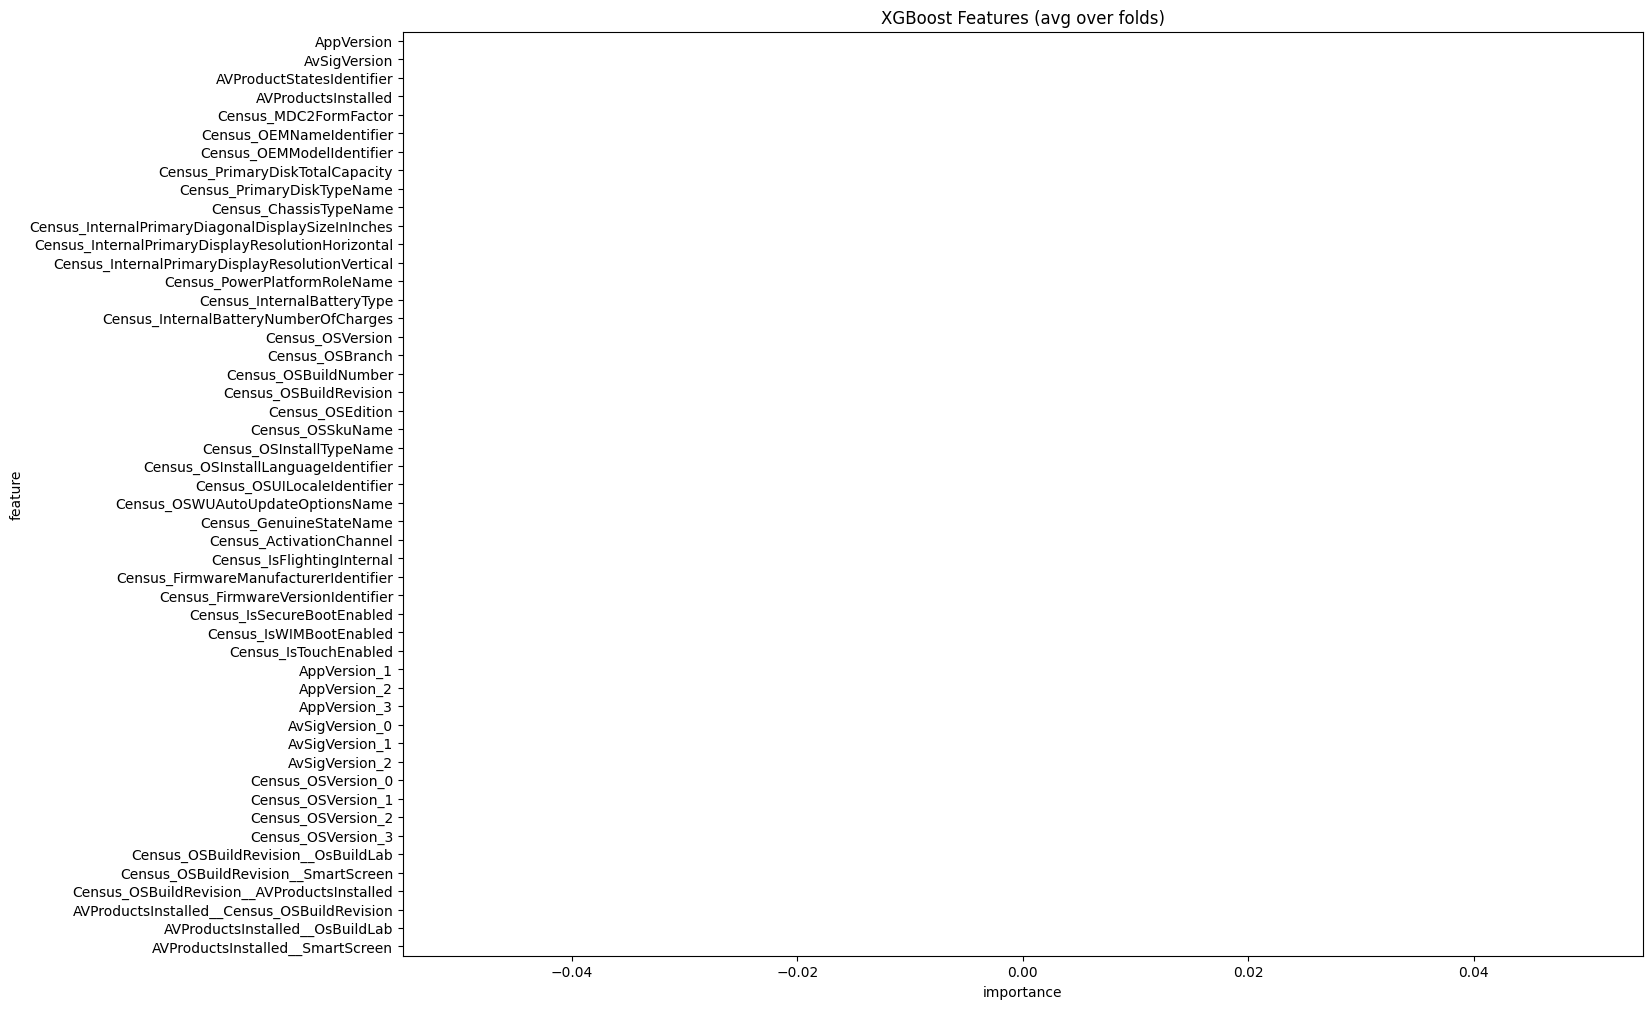

In [63]:
n_splits = 5
folds = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)

# Assuming train1, test, and y1 are already defined
result_dict_xgb = train_model(X=train1, X_test=test, y=y1,model_type='xgb' , params=params_xgb, folds=folds , plot_feature_importance=True, averaging='rank')

In [67]:
submission = pd.read_csv('../microsoft-malware-prediction/sample_submission.csv')

submission['HasDetections'] = result_dict_xgb['prediction']
submission.to_csv('xgb_rank.csv', index=False)
